# Low Rank Tensor Fusion Model - CMU-MOSEI Dataset

In [ ]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Emotion-Recognition

In [2]:
import gdown

file_id = "1zFOBHijVppTiyteSsi0aTFYPEsda_AOk"
destination = "mosei_raw.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk
From (redirected): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk&confirm=t&uuid=b5bfb988-2187-42e0-bf19-9f1440386197
To: /content/mosei_raw.pkl
100%|██████████| 9.94G/9.94G [02:14<00:00, 74.2MB/s]


'mosei_raw.pkl'

## Importing Libraries

In [3]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Emotion-Recognition/src')

## Importing Helper Functions

In [4]:
from loader import get_dataloader
from unimodals.modules import GRUWithLinear, MLP
from fusions.modules import LowRankTensorFusion
from training.supervised import train, test
from utils import get_default_device, save_results

## Loading the Dataset

In [5]:
train_data, valid_data, test_data = get_dataloader('/content/mosei_raw.pkl')

In [6]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [7]:
encoders = [
    GRUWithLinear(713, 64, 32, dropout=True, has_padding=True).to(device),
    GRUWithLinear(74, 128, 32, dropout=True, has_padding=True).to(device),
    GRUWithLinear(300, 512, 128, dropout=True, has_padding=True).to(device)
]

head = MLP(128, 512, 1).to(device)

fusion = LowRankTensorFusion([32, 32, 128], 128, 32).to(device)

/content/Multimodal-Emotion-Recognition/src/fusions/modules.py:124: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(factor)
/content/Multimodal-Emotion-Recognition/src/fusions/modules.py:134: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(self.fusion_weights)


## Training

In [8]:
OUTPUT_MODEL_FILE_NAME = "MOSEI_Low_Rank_Tensor_Fusion"
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    100,
    task="regression",
    optimtype=torch.optim.AdamW,
    early_stop=False,
    is_packed=True,
    lr=1e-3,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/100]
Train Loss: 0.7629
Valid Loss: 0.6507
Saving Best

Epoch [2/100]
Train Loss: 0.6468
Valid Loss: 0.6157
Saving Best

Epoch [3/100]
Train Loss: 0.6102
Valid Loss: 0.5903
Saving Best

Epoch [4/100]
Train Loss: 0.5785
Valid Loss: 0.5927

Epoch [5/100]
Train Loss: 0.5443
Valid Loss: 0.5933

Epoch [6/100]
Train Loss: 0.5054
Valid Loss: 0.5921

Epoch [7/100]
Train Loss: 0.4656
Valid Loss: 0.6544

Epoch [8/100]
Train Loss: 0.4208
Valid Loss: 0.6161

Epoch [9/100]
Train Loss: 0.3870
Valid Loss: 0.6197

Epoch [10/100]
Train Loss: 0.3441
Valid Loss: 0.6007

Epoch [11/100]
Train Loss: 0.3171
Valid Loss: 0.6143

Epoch [12/100]
Train Loss: 0.2887
Valid Loss: 0.6107

Epoch [13/100]
Train Loss: 0.2650
Valid Loss: 0.6095

Epoch [14/100]
Train Loss: 0.2462
Valid Loss: 0.6257

Epoch [15/100]
Train Loss: 0.2317
Valid Loss: 0.6306

Epoch [16/100]
Train Loss: 0.2164
Valid Loss: 0.6137

Epoch [17/100]
Train Loss: 0.2119
Valid Loss: 0.6209

Epoch [18/100]
Train Loss: 0.1980
Valid Loss: 0.6242

E

Text(0.5, 1.0, 'Loss vs. No. of epochs')

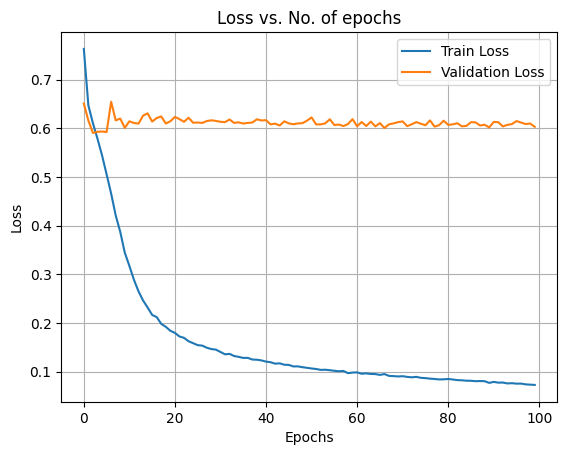

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [10]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [11]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_dataloaders_all=test_data,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-11-ece7b266be51>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)


Recall: 80.9458% | Total Accuracy: 70.9567%
Inference Time: 2s265ms
Inference Params: 1616641
